# Console Deployment

This notebook showcases how the **Drowning Detection System** is applied directly within the notebook for:

- **Video File Inference**  
  We run inference on pre-recorded swimming pool footage to detect and classify human behaviors such as *swimming*, *treading water*, and *drowning*.

- **Live Webcam Streaming**  
  The system captures frames from a live webcam feed, overlays predictions (with timestamp), and streams the output back in real time. This emulates real-world deployment for poolside surveillance or lifeguard assist systems.

In [1]:
from dotenv import load_dotenv

load_dotenv()

import sys
import os

sys.path.append(os.getenv('SRC_DIR'))

from utils.system import display_system_info

display_system_info(markdown=True)


**Last Updated**: 2025-04-29 02:48:52

**Python Version**: 3.11.12  
**OS**: Windows 10.0.26100  
**Architecture**: 64bit  
**Hostname**: ShenLaptop  
**Processor**: Intel64 Family 6 Model 186 Stepping 3, GenuineIntel  
**RAM Size**: 15.65 GB  
  
        

## Function Definition

In [2]:
from pygame import mixer
from ultralytics import YOLO
from classify import TorchClassifier
import torch
from torchvision import transforms
import cv2
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime

ACTIVITY_IDX_TO_NAME = {
    0: 'drowning',
    1: 'swimming',
    2: 'treadwater'
}

YOLO_PATH = Path(r'../models/detection/YOLO/yolo11n.pt')
CNN_PATH = Path(r'../models/classification/CNN/test.pt')
SIREN_PATH = Path(r'../data/audio/siren.wav')

# VIDEO_PATH = os.path.join(PROJECT_ROOT, r"data\videos\manyswimmers.mp4")

def list_available_cameras(max_cameras=5):
    available_cameras = []
    for index in range(max_cameras):
        cap = cv2.VideoCapture(index, cv2.CAP_DSHOW)
        if cap.isOpened():
            available_cameras.append(index)
            cap.release()
    return available_cameras

def save_log(drowning_log_no_roi, path, extension='.csv'):
    df_log = pd.DataFrame(
        drowning_log_no_roi,
        columns=["timestamp", "object_id", "drowning_probability"]
    )

    df_log.to_csv(str(path)+extension, index=False)


def save_video(output_frames, path, extension='.mp4', codec='H264'):
    # Save to a new video file
    fourcc = cv2.VideoWriter_fourcc(*codec)
    out = cv2.VideoWriter(str(path)+extension, fourcc, 30.0, (output_frames[0].shape[1], output_frames[0].shape[0]))

    for frame in output_frames:
        out.write(frame)

    out.release()

def display_drowning_log(drowning_log):
    for log in drowning_log:
        fig, ax = plt.subplots(1, 2, figsize=(8, 4))

        ax[0].axis('off')
        text = (f"Timestamp: {log['timestamp']}\n"
                f"Object ID: {log['object_id']}\n"
                f"Drowning Probability: {log['drowning_probability']:.2f}")
        ax[0].text(0.5, 0.5, text, ha='center', va='center', fontsize=12)

        ax[1].imshow(cv2.cvtColor(log['roi'], cv2.COLOR_BGR2RGB))
        ax[1].axis('off')

        plt.tight_layout()
        plt.show()

def log_drowning_info(drowning_log, drowning_log_no_roi, log):
    timestamp, obj_id, drowning_prob, roi = log
    drowning_prob = float(drowning_prob) 

    log_entry = {
        "timestamp": timestamp,
        "object_id": obj_id,
        "drowning_probability": drowning_prob,
        "roi": roi
    }

    log_entry_no_roi = [timestamp, obj_id, drowning_prob]

    drowning_log.append(log_entry)
    drowning_log_no_roi.append(log_entry_no_roi)


def classify_activity(model, roi):
    class RGBToHSV:
        def __call__(self, img):
            # Ensure the image is in PIL format before converting
            if isinstance(img, torch.Tensor):
                img = transforms.ToPILImage()(img)  # Convert tensor to PIL image

            return img.convert("HSV") # Convert to HSV

    roi_pil = Image.fromarray(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))

    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        RGBToHSV(),
        transforms.ToTensor()
    ])

    prediction = model(
        img=roi_pil,
        transform=transform,
        prob=True
    )

    return prediction.cpu().numpy() # Convert to numpy array


def detect_drowning(detection_model, classification_model, obj_confs_info, class_confs_info, frame, sensitivity):
    drowning_idx = [key for key, value in ACTIVITY_IDX_TO_NAME.items() if value == "drowning"][0]

    activate_siren = False
    drowning_info_logs = []
    annotated_frame = frame.copy()

    result = detection_model.track(frame, persist=True, tracker="botsort.yaml", verbose=False)[0]

    if result.boxes and result.boxes.id is not None:
        obj_boxes = result.boxes.xyxy.cpu().numpy()
        obj_ids = map(int, result.boxes.id.cpu().numpy())
        obj_confs = result.boxes.conf.cpu().numpy()

        for box, obj_id, obj_conf in zip(obj_boxes, obj_ids, obj_confs):
            if obj_id not in obj_confs_info or obj_id not in class_confs_info:
                current_obj_conf_count = None
                current_activity_vec = None
            else:
                current_obj_conf_count = obj_confs_info[obj_id]
                current_activity_vec = class_confs_info[obj_id]

            # Update objectnesss confidence
            new_obj_conf = obj_confs_info[obj_id] = (
                ((1 - sensitivity) *
                 current_obj_conf_count[0] + sensitivity * obj_conf, current_obj_conf_count[1] + 1)
                if current_obj_conf_count is not None else
                (obj_conf, 1)
            )

            if new_obj_conf[0] < 0.5:  # Object confidence threshold
                continue

            x1, y1, x2, y2 = map(int, box)
            roi = frame[y1:y2, x1:x2]

            # Classify the activity in the ROI
            activity_vec = classify_activity(classification_model, roi)
            new_activity_vec = class_confs_info[obj_id] = (
                (1 - sensitivity) *
                current_activity_vec[0] + sensitivity * activity_vec
                if current_activity_vec is not None else
                activity_vec
            )

            if new_obj_conf[1] < 20:  # Number of frames required before drawing detection
                continue

            # Get the predicted activity and corresponding probability
            predicted_activity_idx = int(np.argmax(new_activity_vec))
            predicted_activity_name = ACTIVITY_IDX_TO_NAME[predicted_activity_idx]
            drowning_prob = float(np.clip(new_activity_vec[drowning_idx], 0, 1)) # Clamp the drowning probability to [0, 1]

            bgr = 0, int(255 * (1 - drowning_prob)), int(255 * drowning_prob) # Interpolate: red = (0, 0, 255), green = (0, 255, 0)

            # Draw the bounding box and label
            cv2.rectangle(annotated_frame, (x1, y1), (x2, y2), bgr, 2)
            cv2.putText(annotated_frame, f'{obj_id} {predicted_activity_name} {drowning_prob * 100:.2f}%', (
                x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, bgr, 1)

            if predicted_activity_name == "drowning":
                activate_siren = True
                drowning_info_logs.append((datetime.now().strftime('%Y-%m-%d %H:%M:%S'), obj_id, drowning_prob, roi))

    cv2.putText(annotated_frame, f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}",
                (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

    return annotated_frame, activate_siren, drowning_info_logs


def detection(cap, sensitivity, detection_model, classification_model, siren=None, get_annotated_frames=False):
    obj_confs_info = {}
    class_confs_info = {}
    drowning_log = []
    drowning_log_no_roi = []
    output_frames = []
    
    print(50 * '-')
    print("Press 'q' to exit the program.")    
    print(50 * '-')
    
    while True:
        ret, frame = cap.read()

        if not ret:
            print("End of video stream")
            break

        annotated_frame, activate_siren, drowning_info_logs = detect_drowning(
            detection_model,
            classification_model,
            obj_confs_info,
            class_confs_info,
            frame,
            sensitivity
        )

        for log in drowning_info_logs:
            log_drowning_info(drowning_log, drowning_log_no_roi, log)

        cv2.namedWindow("Console Deployment", cv2.WINDOW_NORMAL)
        cv2.resizeWindow("Console Deployment", 1000, 600)
        cv2.imshow("Console Deployment", annotated_frame)

        if activate_siren:
            if siren is not None and not siren.get_busy():
                siren.play()
            print("\033[91mDrowning detected!            \033[0m", end='\r')  # red text
        else:
            if siren is not None and siren.get_busy():
                siren.fadeout(1000)
            print(" " * 30, end='\r') 

        if get_annotated_frames:
            output_frames.append(annotated_frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()
    if siren is not None and siren.get_busy():
        siren.fadeout(1000)

    if get_annotated_frames:
        return drowning_log, drowning_log_no_roi, output_frames
    else:
        return drowning_log, drowning_log_no_roi


def run_detection_system(
    sensitivity=0.5,
    yolo_path=YOLO_PATH,
    cnn_path=CNN_PATH,
    siren_path=SIREN_PATH
):
    detection_type = input("Enter 'video' for video detection or 'camera' for live camera detection: ").strip().lower()

    if detection_type not in ["video", "camera", "v", "c"]:
        raise ValueError("Invalid input. Please enter [video] or [camera]!!")
    
    # Model configurations
    detection_model = YOLO(yolo_path)
    classification_model = TorchClassifier(model="CNNClassifier", model_path=cnn_path)
    
    # Siren configurations
    mixer.init()
    mixer.music.load(siren_path)
    siren = mixer.music

    if detection_type in ["video", "v"]:
        video_path = input("Enter the path to the video file: ").strip()
        cap = cv2.VideoCapture(video_path)

        if not cap.isOpened():
            raise RuntimeError(f"Failed to open video file {video_path}. Please check the file path.")
        
        get_annotated_frames=True

    elif detection_type in ["camera", "c"]:
        available_cameras = list_available_cameras()

        if len(available_cameras) == 0:
            raise RuntimeError("No available cameras found. Please connect a camera and try again.")
        
        camera_no = int(input("Enter the camera number %s (Default 0): " % ("[0]" if len(available_cameras) < 2 else f"[0 - {max(available_cameras)}]")).strip() or 0)
        cap = cv2.VideoCapture(camera_no, cv2.CAP_DSHOW) # Only cv::CAP_DSHOW works on logitech C270, not cv::CAP_MSMF and cv::CAP_V4L2.

        if not cap.isOpened():
            raise RuntimeError(f"Failed to open camera {camera_no}. Please check if the camera is connected and not used by another application.")

        get_annotated_frames=False

    return detection(cap, sensitivity, detection_model, classification_model, siren, get_annotated_frames)

pygame 2.6.1 (SDL 2.28.4, Python 3.11.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Live Detection

In [3]:
live_drowning_log, live_drowning_log_no_roi = run_detection_system(
    0.5,
    Path(r'../models/detection/YOLO/yolo11n.pt'),
    Path(r'../models/classification/CNN/test.pt'),
    Path(r'../data/audio/siren.wav')
)

--------------------------------------------------
Press 'q' to exit the program.
--------------------------------------------------


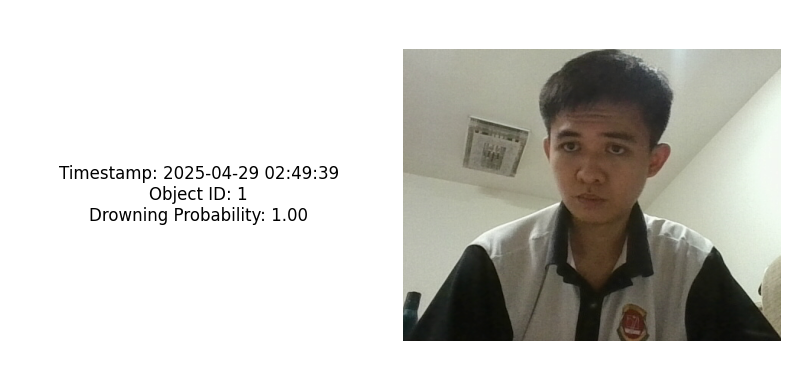

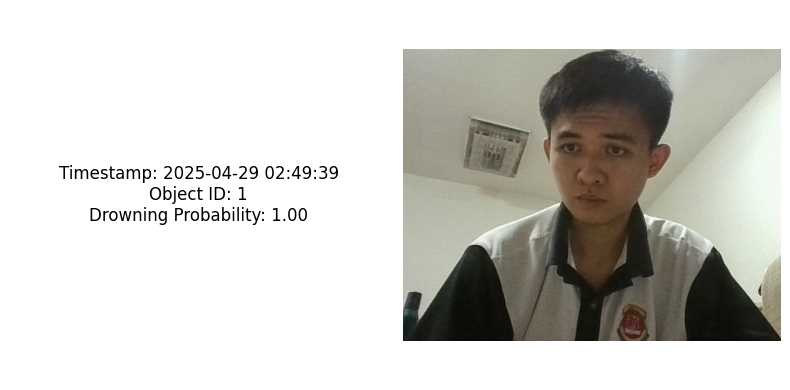

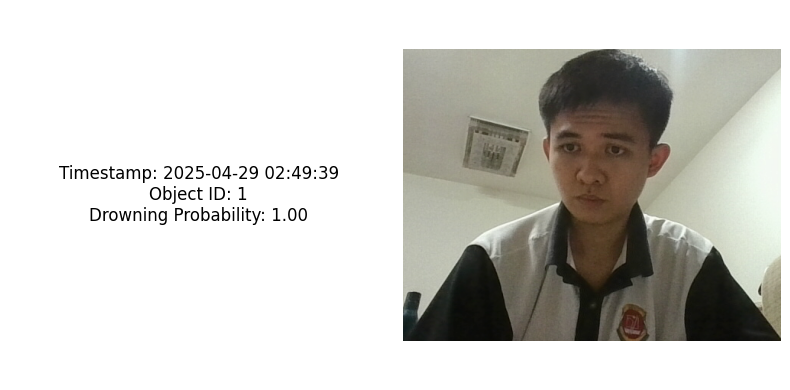

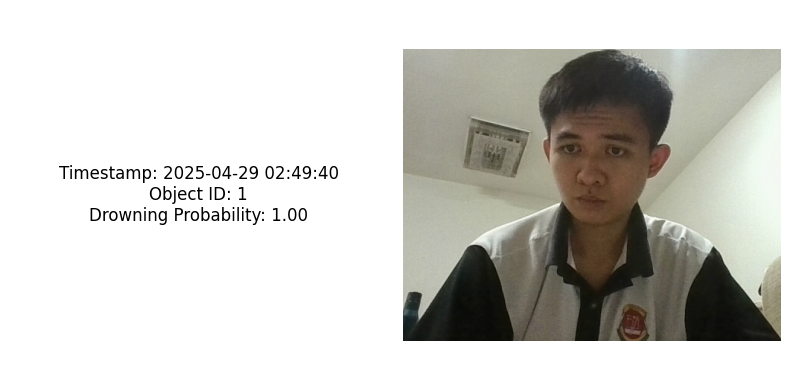

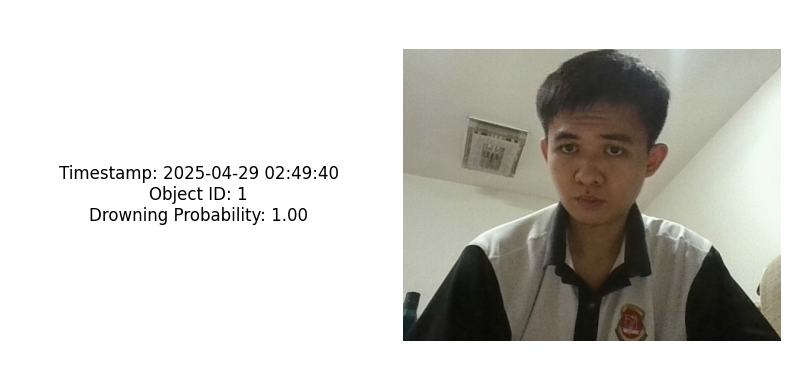

In [4]:
display_drowning_log(live_drowning_log[:5])

In [5]:
save_log(live_drowning_log_no_roi, Path(r'../console/outputs/live_drowning_log_no_roi'), extension='.csv')

## Video Detection

In [6]:
video_drowning_log, video_drowning_log_no_roi, video_frames = run_detection_system(
    0.5,
    Path(r'../models/detection/YOLO/jrom_yolo11n.pt'),
    Path(r'../models/classification/CNN/test.pt'),
    Path(r'../data/audio/siren.wav')
)

# C:\Users\hp\Downloads\Drowning-Detection\data\videos\kid_help.mp4

--------------------------------------------------
Press 'q' to exit the program.
--------------------------------------------------
End of video stream                


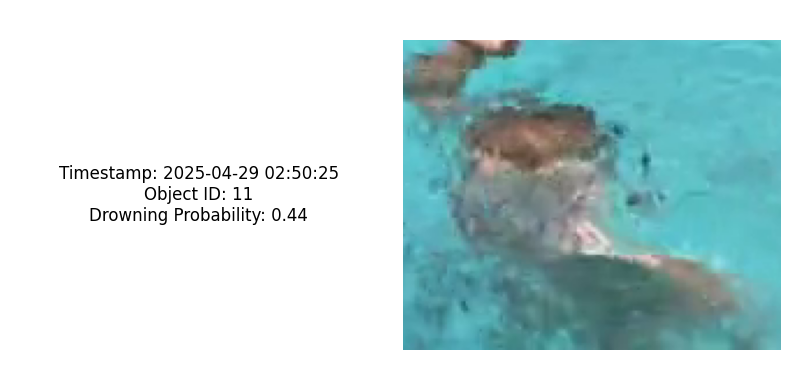

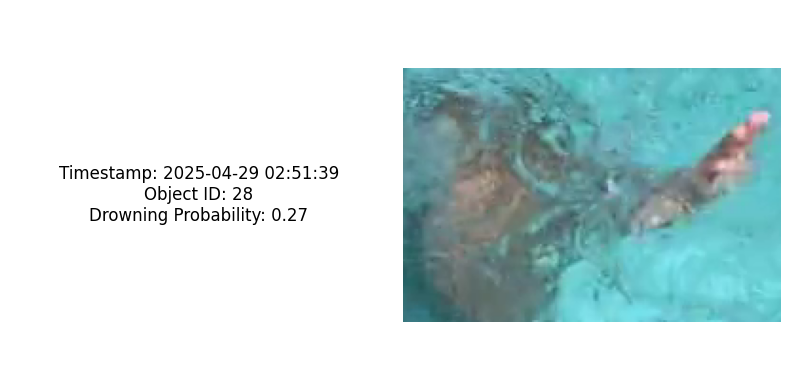

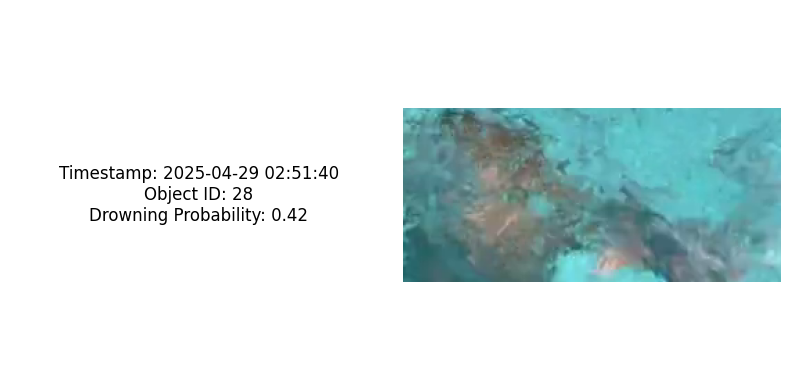

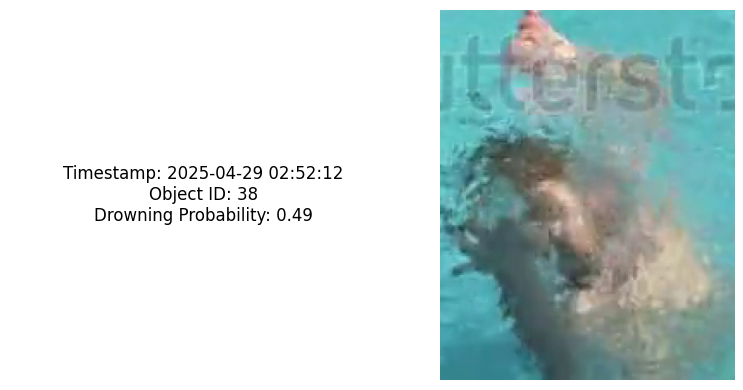

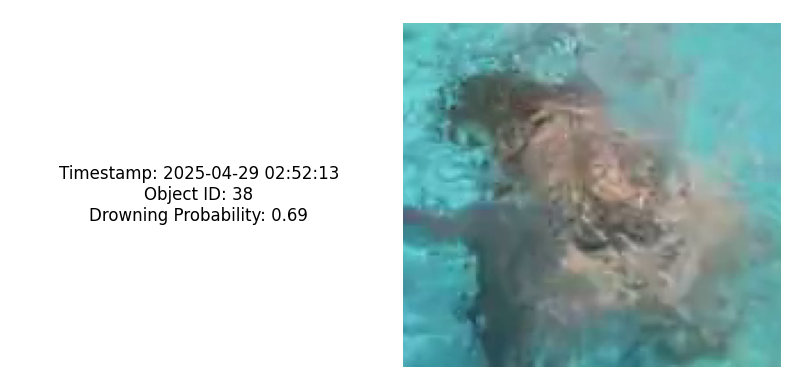

In [7]:
display_drowning_log(video_drowning_log[:5])

In [8]:
save_log(video_drowning_log_no_roi, Path(r'../console/outputs/video_drowning_log_no_roi2'), extension='.csv')
save_video(video_frames, Path(r'../console/outputs/video_drowning_annotated2'), extension='.mp4')

## Testing Real-Time Performance

In [16]:
import time

def get_real_time_performance(n_runs=5):
    def decorator(fun):
        def wrapper(*args, **kwargs):
            elapsed_times = []
            fps_list = []
            frame_counts = []
            resolutions = []

            for i in range(n_runs):
                start_time = time.time()
                width, height, frame_count = fun(*args, **kwargs)
                end_time = time.time()

                elapsed = end_time - start_time
                fps = (frame_count / elapsed) if elapsed > 0 else 0

                elapsed_times.append(elapsed)
                fps_list.append(fps)
                frame_counts.append(frame_count)
                resolutions.append((width, height))

                print(f"Run {i+1}: {elapsed:.2f}s elapsed, {fps:.2f} FPS, Resolution: {width}x{height}")

            elapsed_times = np.array(elapsed_times)
            fps_list = np.array(fps_list)
            frame_counts = np.array(frame_counts)

            width_set = {w for (w, h) in resolutions}
            height_set = {h for (w, h) in resolutions}

            print("\n=== Summary over {} runs ===".format(n_runs))
            if len(width_set) == 1 and len(height_set) == 1:
                width, height = resolutions[0]
                print(f"Video Resolution: {width}x{height}")
            else:
                print("Video Resolution: Varies across runs")

            time_per_frame_list = elapsed_times / frame_counts  # New line

            print(f"Elapsed time: {elapsed_times.mean():.2f} ± {elapsed_times.std():.2f} seconds")
            print(f"FPS: {fps_list.mean():.2f} ± {fps_list.std():.2f} frames per second")
            print(f"Processed frames per run (avg): {frame_counts.mean():.0f}")
            print(f"Time taken per frame: {time_per_frame_list.mean():.4f} ± {time_per_frame_list.std():.4f} seconds")

            return frame_counts.mean(), elapsed_times.mean(), fps_list.mean()
        return wrapper
    return decorator

def video_fun(path, sensitivity, yolo_path, cnn_path):
    cap = cv2.VideoCapture(path)

    frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    width, height = cap.get(cv2.CAP_PROP_FRAME_WIDTH), cap.get(cv2.CAP_PROP_FRAME_HEIGHT)

    # Model configurations
    detection_model = YOLO(yolo_path)
    classification_model = TorchClassifier(model="CNNClassifier", model_path=cnn_path)

    if not cap.isOpened():
        raise RuntimeError(f"Failed to open video file {path}. Please check the file path.")
    
    detection(cap, sensitivity, detection_model, classification_model)

    return width, height, frame_count

@get_real_time_performance(n_runs=5)
def rt_performance_video(path, sensitivity, yolo_path, cnn_path):
    return video_fun(path, sensitivity, yolo_path, cnn_path)

In [17]:
frame_count, elapsed_time, fps = rt_performance_video(
    Path(r'C:\Users\hp\Downloads\Drowning-Detection\data\videos\kid_help.mp4'),
    0.5,
    Path(r'../models/detection/YOLO/jrom_yolo11n.pt'),
    Path(r'../models/classification/CNN/test.pt'),
)

--------------------------------------------------
Press 'q' to exit the program.
--------------------------------------------------
End of video stream                
Run 1: 131.90s elapsed, 3.71 FPS, Resolution: 898.0x506.0
--------------------------------------------------
Press 'q' to exit the program.
--------------------------------------------------
End of video stream                
Run 2: 133.08s elapsed, 3.68 FPS, Resolution: 898.0x506.0
--------------------------------------------------
Press 'q' to exit the program.
--------------------------------------------------
End of video stream                
Run 3: 128.35s elapsed, 3.82 FPS, Resolution: 898.0x506.0
--------------------------------------------------
Press 'q' to exit the program.
--------------------------------------------------
End of video stream                
Run 4: 127.74s elapsed, 3.84 FPS, Resolution: 898.0x506.0
--------------------------------------------------
Press 'q' to exit the program.
----------

In [18]:
frame_count, elapsed_time, fps = rt_performance_video(
    Path(r'C:\Users\hp\Downloads\Drowning-Detection\data\videos\many_swim_2.mp4'),
    0.5,
    Path(r'../models/detection/YOLO/jrom_yolo11n.pt'),
    Path(r'../models/classification/CNN/test.pt'),
)

--------------------------------------------------
Press 'q' to exit the program.
--------------------------------------------------
End of video stream                
Run 1: 423.28s elapsed, 1.29 FPS, Resolution: 1280.0x720.0
--------------------------------------------------
Press 'q' to exit the program.
--------------------------------------------------
End of video stream                
Run 2: 419.94s elapsed, 1.30 FPS, Resolution: 1280.0x720.0
--------------------------------------------------
Press 'q' to exit the program.
--------------------------------------------------
End of video stream                
Run 3: 442.67s elapsed, 1.23 FPS, Resolution: 1280.0x720.0
--------------------------------------------------
Press 'q' to exit the program.
--------------------------------------------------
End of video stream                
Run 4: 425.15s elapsed, 1.28 FPS, Resolution: 1280.0x720.0
--------------------------------------------------
Press 'q' to exit the program.
------